# **Khởi tạo**

**Import thư viện**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
from sklearn.metrics import mean_absolute_error
import os

**Xử lý dữ liệu**

In [2]:
def read_file(file_name):
    # Đọc dữ liệu từ file CSV
    data = pd.read_csv(file_name)

    # Chuyển cột 'Date' thành kiểu dữ liệu datetime và đặt làm index
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

    # Chuyển đổi các cột khác sang dạng số nếu cần thiết
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    # Tiền xử lý các cột khác nếu cần thiết

    # Sắp xếp dữ liệu theo thời gian từ quá khứ đến hiện tại
    data.sort_index(inplace=True)
    data = data.reset_index()['Price']

    return data

**Xây dựng mô hình**

In [3]:
# Hàm tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [4]:
# Hàm Create Dataset
def create_dataset(dataset, seq_size=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-seq_size-1):
        window = dataset[i:(i+seq_size), 0]
        dataX.append(window)
        dataY.append(dataset[i + seq_size, 0])
    return np.array(dataX), np.array(dataY)

In [5]:
def GRU_prediction(name, file_name, train_ratio=0.7, test_ratio=0.2, forecast_days=30):
    # Đọc dữ liệu từ file CSV
    data = read_file(file_name)
    
    # Scaler data
    scaler = MinMaxScaler(feature_range=(0,1))
    data = scaler.fit_transform(np.array(data).reshape(-1,1))

    # Chia train, test
    train_size = int(train_ratio * len(data))
    test_size = int(test_ratio * len(data))
    train_data = data[:train_size]
    test_data = data[train_size:train_size+test_size]
    
    # Reshape into X=t,t+1,t+2..t+99 and Y=t+100
    time_step = 100
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)

    # Reshape input to be [samples, time steps, features] which is required for LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Define GRU Model
    model = Sequential()
    model.add(GRU(64, input_shape=(time_step, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Fit mô hình với dữ liệu train
    model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)

    # Dự báo dữ liệu test
    train_predict = model.predict(X_train)
    y_pred = model.predict(X_test)

    # Chuẩn hóa dữ liệu y_pred
    train_predict=scaler.inverse_transform(train_predict)
    y_pred=scaler.inverse_transform(y_pred)
    # Chuẩn hóa dữ liệu y_test
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Đánh giá độ chính xác thuật toán bằng RMSE
    test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
    print('Testing RMSE:', test_rmse)

    # Đánh giá độ chính xác thuật toán bằng MAE
    test_mae = mean_absolute_error(y_test, y_pred)
    print('Testing MAE:', test_mae)
    
    # Đánh giá độ chính xác thuật toán bằng MAPE
    test_mape = mean_absolute_percentage_error(y_test, y_pred)
    print('Testing MAPE:', test_mape)
    
    # Dự báo n ngày tiếp theo
    x_input = test_data[-time_step:].reshape(1, -1)
    temp_input = list(x_input[0])
    lst_output = []

    while len(lst_output) < forecast_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape(1, -1)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
        else:
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())

    # Vẽ hình
    plt.title('GRU {} ({})'.format(train_ratio, name))
    plt.plot(scaler.inverse_transform(train_data))
    test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
    plt.plot(test_data_index, scaler.inverse_transform(test_data))
    test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
    plt.plot(test_data_index, y_pred)
    predict_data_index = pd.RangeIndex(start=len(data), stop=len(data)+forecast_days, step=1)
    plt.plot(predict_data_index, scaler.inverse_transform(lst_output))
    plt.legend(['Train', 'Test', 'Predict', f'Predict {forecast_days} days'])
    plt.show()
    

# **BIDV**

## **30 ngày**

**BIDV 7:3 predict 30 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Testing RMSE: 893.8951591560401
Testing MAE: 631.8351348458906
Testing MAPE: 1.487680701662668


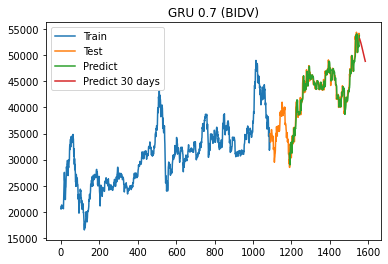

In [6]:
GRU_prediction('BIDV', '../Dataset/BID Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=30)

**BIDV 8:2 predict 30 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Testing RMSE: 869.3034432586147
Testing MAE: 623.1734933035717
Testing MAPE: 1.3647980252241245


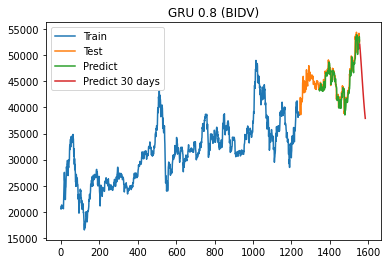

In [7]:
GRU_prediction('BIDV', '../Dataset/BID Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=30)

**BIDV 9:1 predict 30 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Testing RMSE: 950.0234678288455
Testing MAE: 724.1095196759256
Testing MAPE: 1.4450979654712683


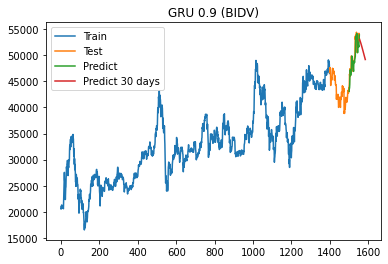

In [8]:
GRU_prediction('BIDV', '../Dataset/BID Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=30)

## **60 ngày**

**BIDV 7:3 predict 60 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Testing RMSE: 890.6135095156342
Testing MAE: 632.1665881849315
Testing MAPE: 1.483807444728168


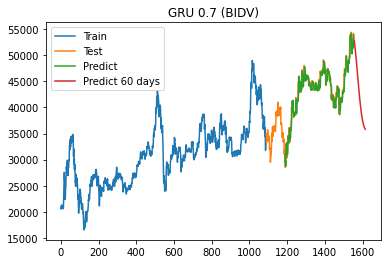

In [9]:
GRU_prediction('BIDV', '../Dataset/BID Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=60)

**BIDV 8:2 predict 60 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Testing RMSE: 843.1791752342322
Testing MAE: 597.4755766369049
Testing MAPE: 1.308687017040482


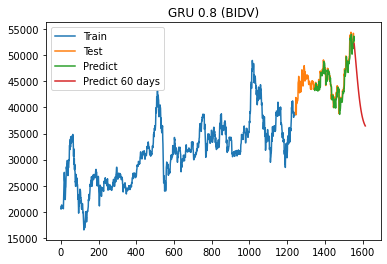

In [10]:
GRU_prediction('BIDV', '../Dataset/BID Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=60)

**BIDV 9:1 predict 60 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Testing RMSE: 1212.7456291133533
Testing MAE: 926.8317418981482
Testing MAPE: 1.8518108015976487


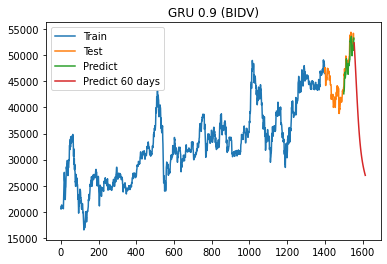

In [11]:
GRU_prediction('BIDV', '../Dataset/BID Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=60)

## **90 ngày**

**BIDV 7:3 predict 90 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Testing RMSE: 1078.8893908233047
Testing MAE: 841.2105682791096
Testing MAPE: 1.951822566731267


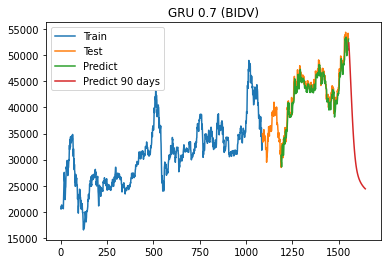

In [12]:
GRU_prediction('BIDV', '../Dataset/BID Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=90)

**BIDV 8:2 predict 90 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Testing RMSE: 832.9577011682861
Testing MAE: 586.0666852678571
Testing MAPE: 1.2851249610945783


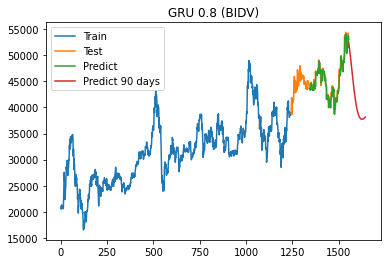

In [13]:
GRU_prediction('BIDV', '../Dataset/BID Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=90)

**BIDV 9:1 predict 90 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Testing RMSE: 1021.2935475134404
Testing MAE: 774.7134693287031
Testing MAPE: 1.547456579903299


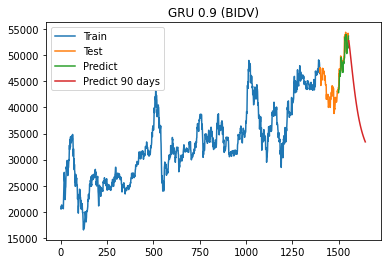

In [14]:
GRU_prediction('BIDV', '../Dataset/BID Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=90)

# **VCB**

## **30 ngày**

**VCB 7:3 predict 30 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Testing RMSE: 1711.9690829023577
Testing MAE: 1179.7111729452056
Testing MAPE: 1.3485683150751926


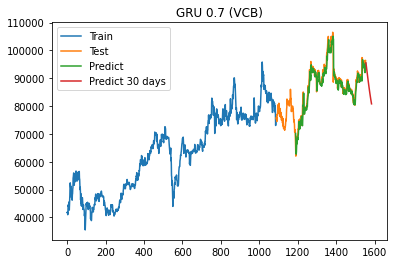

In [15]:
GRU_prediction('VCB', '../Dataset/VCB Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=30)

**VCB 8:2 predict 30 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Testing RMSE: 1632.195301715243
Testing MAE: 951.6918898809524
Testing MAPE: 1.0424926761359892


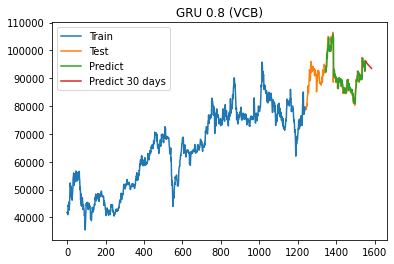

In [16]:
GRU_prediction('VCB', '../Dataset/VCB Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=30)

**VCB 9:1 predict 30 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Testing RMSE: 1328.047748841369
Testing MAE: 936.0328414351852
Testing MAPE: 1.013709262407586


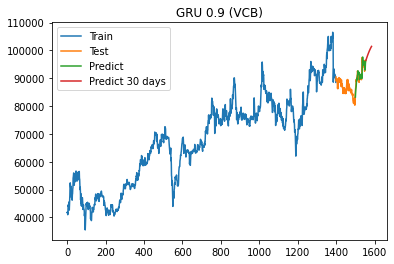

In [17]:
GRU_prediction('VCB', '../Dataset/VCB Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=30)

## **60 ngày**

**VCB 7:3 predict 60 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Testing RMSE: 1734.2297029830295
Testing MAE: 1192.8428296232878
Testing MAPE: 1.3643153764859264


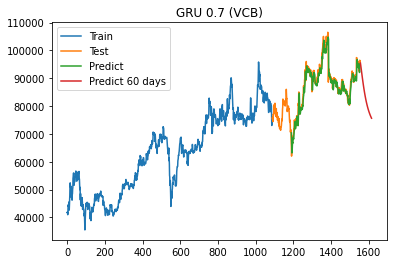

In [18]:
GRU_prediction('VCB', '../Dataset/VCB Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=60)

**VCB 8:2 predict 60 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Testing RMSE: 1654.519496508662
Testing MAE: 985.0090401785717
Testing MAPE: 1.0751529004325058


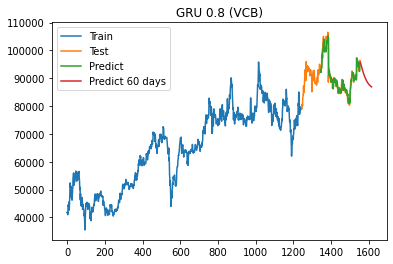

In [19]:
GRU_prediction('VCB', '../Dataset/VCB Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=60)

**VCB 9:1 predict 60 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Testing RMSE: 1514.7666154936412
Testing MAE: 1033.1828703703698
Testing MAPE: 1.1217880667593825


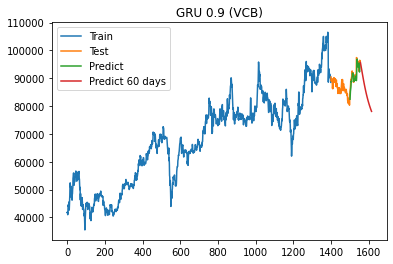

In [20]:
GRU_prediction('VCB', '../Dataset/VCB Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=60)

## **90 ngày**

**VCB 7:3 predict 90 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Testing RMSE: 1662.2628627775075
Testing MAE: 1102.4552761130142
Testing MAPE: 1.2686834380111471


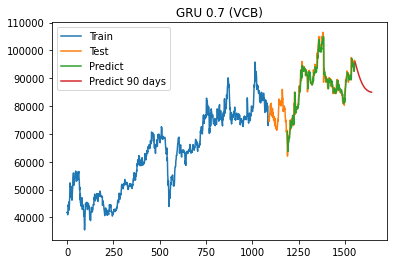

In [21]:
GRU_prediction('VCB', '../Dataset/VCB Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=90)

**VCB 8:2 predict 90 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Testing RMSE: 1784.1591133305953
Testing MAE: 1155.4770089285712
Testing MAPE: 1.256135101713376


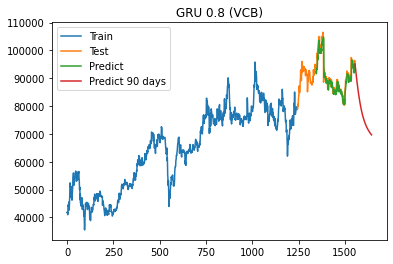

In [22]:
GRU_prediction('VCB', '../Dataset/VCB Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=90)

**VCB 9:1 predict 90 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Testing RMSE: 1335.4537039219401
Testing MAE: 909.6811342592592
Testing MAPE: 0.9861338813398774


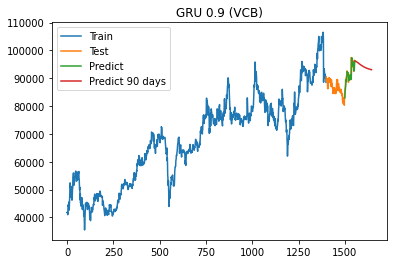

In [23]:
GRU_prediction('VCB', '../Dataset/VCB Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=90)

# **MBB**

## **30 ngày**

**MBB 7:3 predict 30 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Testing RMSE: 425.28100391345345
Testing MAE: 285.1784669306507
Testing MAPE: 1.5326333932830976


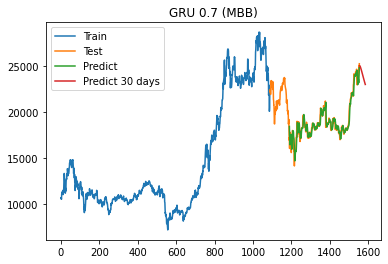

In [24]:
GRU_prediction('MBB', '../Dataset/MBB Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=30)

**MBB 8:2 predict 30 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Testing RMSE: 366.57370961715037
Testing MAE: 234.88413690476196
Testing MAPE: 1.1699503766626402


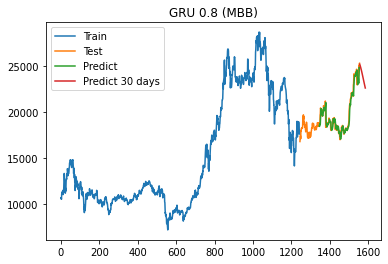

In [25]:
GRU_prediction('MBB', '../Dataset/MBB Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=30)

**MBB 9:1 predict 30 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Testing RMSE: 447.96383600588086
Testing MAE: 326.3976056134258
Testing MAPE: 1.4305465297888609


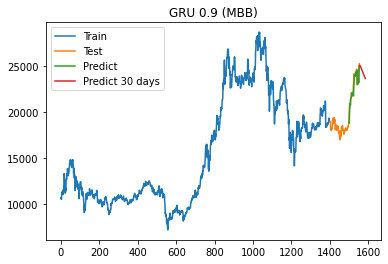

In [26]:
GRU_prediction('MBB', '../Dataset/MBB Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=30)

## **60 ngày**

**MBB 7:3 predict 60 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Testing RMSE: 427.4585100508212
Testing MAE: 285.26328874143854
Testing MAPE: 1.5362431848628975


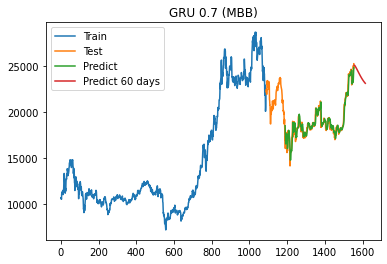

In [27]:
GRU_prediction('MBB', '../Dataset/MBB Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=60)

**MBB 8:2 predict 60 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Testing RMSE: 356.3573431684757
Testing MAE: 225.90364955357148
Testing MAPE: 1.1260478665238376


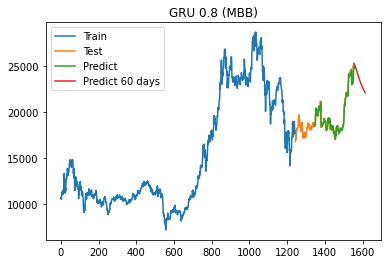

In [28]:
GRU_prediction('MBB', '../Dataset/MBB Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=60)

**MBB 9:1 predict 60 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Testing RMSE: 439.14016902037025
Testing MAE: 317.99649160879613
Testing MAPE: 1.3936458288245277


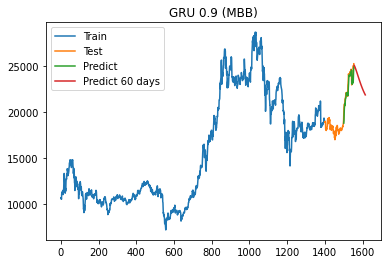

In [29]:
GRU_prediction('MBB', '../Dataset/MBB Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=60)

## **90 ngày**

**MBB 7:3 predict 90 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Testing RMSE: 442.44525831917144
Testing MAE: 303.674814854452
Testing MAPE: 1.6274148490099702


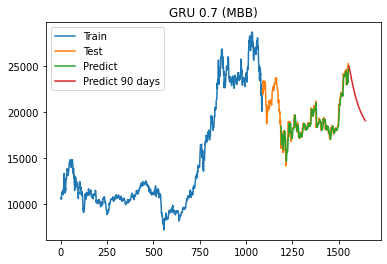

In [30]:
GRU_prediction('MBB', '../Dataset/MBB Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=90)

**MBB 8:2 predict 90 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Testing RMSE: 372.04699693807834
Testing MAE: 238.21358258928598
Testing MAPE: 1.1910329769726273


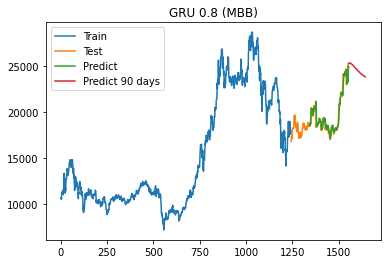

In [31]:
GRU_prediction('MBB', '../Dataset/MBB Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=90)

**MBB 9:1 predict 90 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Testing RMSE: 419.2169785383247
Testing MAE: 332.17129629629613
Testing MAPE: 1.452090048054293


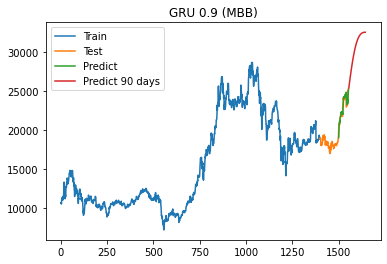

In [32]:
GRU_prediction('MBB', '../Dataset/MBB Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=90)